In [1]:
# load env ------------------------------------------------------------------------
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"


# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose
set_verbose(True)
set_debug(False)

from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    ToolMessage
)
from langgraph.graph import END, StateGraph, START
from agents import(
    AgentState,
    agents,
    agent_name
)
from tools import get_tools_output, all_tools
from chat_history import save_chat_history, load_chat_history
from langgraph.checkpoint.memory import MemorySaver

## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal

tool_node = ToolNode(all_tools)

def router(state) -> Literal["call_tool", "continue", "supervisor", "creative_communication_agent", "crm_agent", "__end__"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        return "__end__"
    if "supervisor" in last_message.content:
        return "supervisor"
    if "creative_communication_agent" in last_message.content:
        return "creative_communication_agent"
    if "crm_agent" in last_message.content:
        return "crm_agent"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    else:
        return "continue"


## Workflow Graph ------------------------------------------------------------------------
workflow = StateGraph(AgentState)

# add agent nodes
for name, value in agents.items():
    workflow.add_node(name, value['node'])
    
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "supervisor",
    router,
    {
        "crm_agent":"crm_agent",
        "creative_communication_agent":"creative_communication_agent",
        "call_tool": "call_tool",
        "__end__": END,
        "continue": END, 
        }
)

workflow.add_conditional_edges(
    "creative_communication_agent",
    router,
    {
        "call_tool": "call_tool",
        "continue": "supervisor", 
        }
)

workflow.add_conditional_edges(
    "crm_agent",
    router,
    {
        "call_tool": "call_tool",
        "continue": "supervisor", 
        }
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_name},
)

workflow.add_edge(START, "supervisor")
graph = workflow.compile()

def submitUserMessage(
    user_input:str, 
    user_id:str="test", 
    keep_chat_history:bool=False, 
    return_reference:bool=False, 
    verbose:bool=False,
    recursion_limit:int=20
    ) -> str:
    
    chat_history = load_chat_history(user_id=user_id) if keep_chat_history else []
    chat_history = chat_history[-8:]
    
    # memory only keep chat history only along agents.
    internal_level_memory = MemorySaver()
    graph = workflow.compile(checkpointer=internal_level_memory)

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
            "chat_history": chat_history
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": recursion_limit, "thread_id":"a"},
    )
    
    if not verbose:
        events = [e for e in events]
        response = list(events[-1].values())[0]
    else:
        for e in events:
            a = list(e.items())[0]
            a[1]['messages'][0].pretty_print()
        
        response = a[1]
    
    response = response["messages"][0].content
    response = utils.format_bot_response(response, markdown=True)
    
    if keep_chat_history:
        save_chat_history(bot_message=response, human_message=user_input, user_id=user_id)
    
    if return_reference:
        return response, get_tools_output()
    else:
        return response

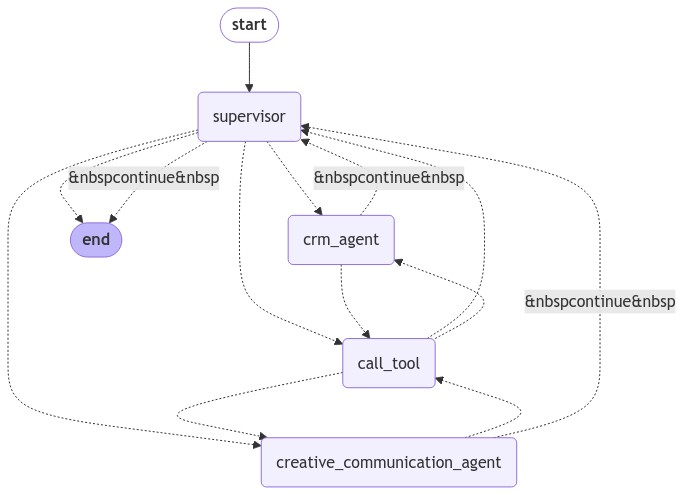

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [3]:
# import utils
result = submitUserMessage("give me my personalized recommendations", keep_chat_history=False, return_reference=True, verbose=True)
utils.notify(sound_effect="purr")

================================== Ai Message ==================================
Name: supervisor

To provide you with personalized recommendations, I need to gather some information about your preferences and lifestyle. I'll forward your request to our CRM Agent to extract relevant customer data. 

Please hold on for a moment while I do that. 

**Forwarding to CRM Agent...** 

`crm_agent` Please extract the relevant customer data for personalized recommendations. Thank you!
================================== Ai Message ==================================
Name: crm_agent
Tool Calls:
  search_retail_store (call_IotVbAiylSYmS9iz0Cs7kVz4)
 Call ID: call_IotVbAiylSYmS9iz0Cs7kVz4
  Args:
    query: personalized recommendations
================================= Tool Message =================================
Name: search_retail_store

[{'_id': 1, 'name': 'Central Mall', 'branch_name': 'Central Mall Prasert-Manukitch Branch', 'location': {'address': '11 Prasert-Manukitch Rd, Lat Phrao, Bangkok 

In [4]:
# submitUserMessage("ราคาเท่าไหร่", keep_chat_history=True, return_reference=True, verbose=True)